##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'"Boom" has garnered itself a something of a reputation. With heavyweights Taylor, Burton, Noel Coward, Tennessee Williams and Joseph Losey, one might be tempted to think, how bad could it be? Well, it\'s a lot worse than you could possibly imagine.<br /><br />The sad and disturbing fact of "Boom" is that is seems to signal the decline and fall of the aforementioned heavyweights. It was only director Joseph Losey who having plummeted the depths with "Modesty Blaise" and "Boom" (some may wish to add "Secret Ceremony"), managed to recuperate and in 1970 create his best work, the wonderful "Go-Between".<br /><br />Saddest of all is the work of Tennesee Williams. From the mid forties until the early sixties, Williams penned a number of plays which have gained classic status, remaining in theater repertory throughout the world, many becoming much praised films. When William\'s muse deserted him, probably owing to his notorious substance abuse, it deserted him for good. Williams at

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  44,   1, ...,   0,   0,   0],
       [  1,   7,   4, ...,   0,   0,   0],
       [ 29,   5, 144, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'"Boom" has garnered itself a something of a reputation. With heavyweights Taylor, Burton, Noel Coward, Tennessee Williams and Joseph Losey, one might be tempted to think, how bad could it be? Well, it\'s a lot worse than you could possibly imagine.<br /><br />The sad and disturbing fact of "Boom" is that is seems to signal the decline and fall of the aforementioned heavyweights. It was only director Joseph Losey who having plummeted the depths with "Modesty Blaise" and "Boom" (some may wish to add "Secret Ceremony"), managed to recuperate and in 1970 create his best work, the wonderful "Go-Between".<br /><br />Saddest of all is the work of Tennesee Williams. From the mid forties until the early sixties, Williams penned a number of plays which have gained classic status, remaining in theater repertory throughout the world, many becoming much praised films. When William\'s muse deserted him, probably owing to his notorious substance abuse, it deserted him for good. Williams 

## Train the model

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 201s 462ms/step - loss: 0.6771 - accuracy: 0.5160 - val_loss: 0.4129 - val_accuracy: 0.8172
Epoch 2/20
391/391 [==============================] - 174s 443ms/step - loss: 0.3983 - accuracy: 0.8229 - val_loss: 0.3542 - val_accuracy: 0.8448
Epoch 3/20
391/391 [==============================] - 173s 441ms/step - loss: 0.3417 - accuracy: 0.8529 - val_loss: 0.3350 - val_accuracy: 0.8505
Epoch 4/20
391/391 [==============================] - 172s 439ms/step - loss: 0.3232 - accuracy: 0.8636 - val_loss: 0.3227 - val_accuracy: 0.8573
Epoch 5/20
391/391 [==============================] - 172s 438ms/step - loss: 0.3099 - accuracy: 0.8695 - val_loss: 0.3362 - val_accuracy: 0.8370
Epoch 6/20
391/391 [==============================] - 173s 441ms/step - loss: 0.3088 - accuracy: 0.8690 - val_loss: 0.3316 - val_accuracy: 0.8385
Epoch 7/20
391/391 [==============================] - 171s 436ms/step - loss: 0.3063 - accuracy: 0.8706 - val_loss: 0.3230 -

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

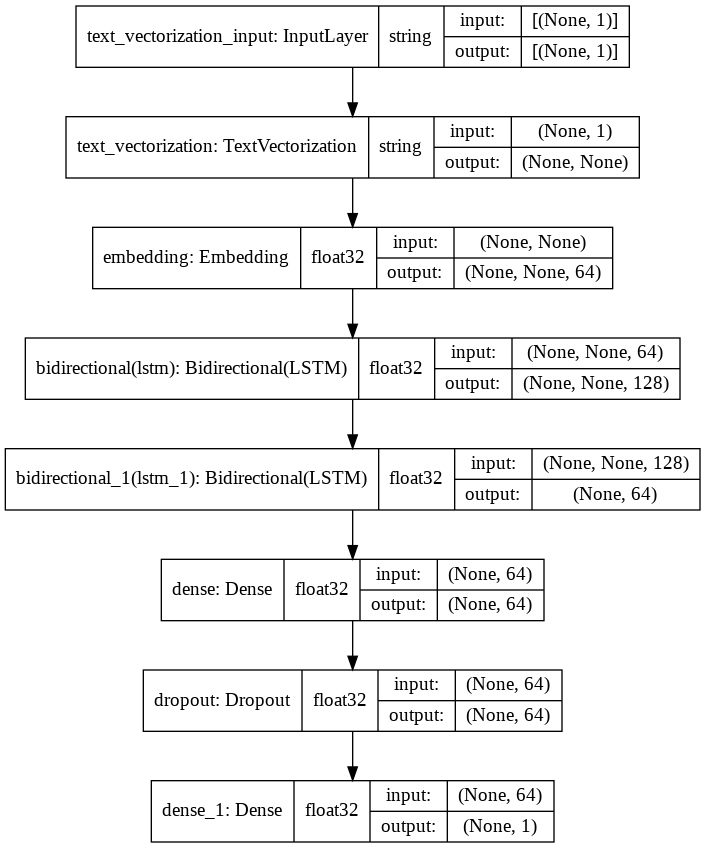

In [19]:
import keras
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [28]:
!pip install -q pyyaml h5py

In [33]:
!mkdir -p saved_model

In [34]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [37]:
# my_model directory
!ls saved_model

my_model


In [39]:
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

assets	saved_model.pb	variables


In [40]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [41]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = new_model.predict(np.array([sample_text]))
print(predictions)

[[-2.3772874]]


In [42]:
test_loss, test_acc = new_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 90s 217ms/step - loss: 0.3274 - accuracy: 0.8517
Test Loss: 0.32740336656570435
Test Accuracy: 0.8516799807548523


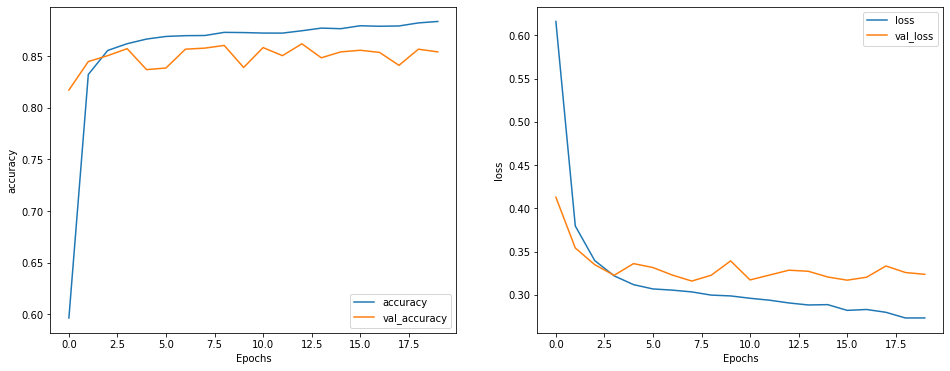

In [43]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')